In [1]:
# this model includes ql
# it uses instantaneous bedrock erosion rate to calc ql
# it uses gamma to represent fraction of plucked material that becomes coarse gravel
# it uses theta to represent fraction of hillslope material that enters fluvial system as coarse 
## (maybe this should be same as gamma, 
## since the real fxn of this parameter is to tell us 
## how much coarse stuff is available for bedload transport/abrasion)

# potential updates: see if adding weighted average back in to ql calculation still allows for stability
## update on the update: this led to stability issues, and it's not worth the time now trying to debug, 
## so just stick with using instantaneous erosion rate. 
## Most interested in steady state profiles anyway, so this is fine.

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# create a profile
dx = 500
x = np.arange(0, 50000, dx)
x_node = x + (dx/2)

# add some elevation
Hstar = 0.5 # depth decay
etab = np.zeros(len(x)) # bedrock elevation
etab[:] = np.linspace(1, 0.1, len(x)) # need to start with slight bedrock slope
H = Hstar + np.zeros(len(x)) # alluvium thickness
eta = etab + H # topography

In [4]:
# define constants and other parameters
K = 1e-7 # erodibility
beta = 0.0005 # abradability
r = 5. # runoff rate
U = 0.0001 # uplift or baselevel fall rate
I = 0.01 # intermittency
phi = 0.1 # porosity
D = 0.01 # grain size
gamma = 0.625 # fraction plucked that becomes coarse
theta = 0.625 # fraction hillslope that enters as coarse
# treat as same!!! Point is what fraction becomes coarse
# so just be sure to change these together

kqs = 0.041 # sed transport coeff
kxb = 25 # valley width coeff
Pxb = 1./5. # valley width exp
kb = 8.3e-8 # channel width coeff

B_valley = kxb * (x_node**Pxb) # valley width
# Q = (r * kxb * x_node**(1 + Pxb))/(1 + Pxb) # discharge
A = (1./3.) * (x**2)
Q = r * A

In [5]:
def model(x, dx, x_node,
          K, beta, gamma, theta,
          D, phi, Hstar,
          kb, kqs, I, r, U,
          etab, H, eta,
          B_valley, Q,
          num_steps = 1):
    
    q = Q/B_valley
    dt = 50
    
    run_duration = dt * num_steps
    cum_time = 0.0
    
    Qs = np.zeros(len(x))
    qs = np.zeros(len(x))
    Eb_p = np.zeros(len(x))
    Eb_a = np.zeros(len(x))
    Eb = np.zeros(len(x))
    Eh = np.zeros(len(x))
    E = np.zeros(len(x))
    ql = np.zeros(len(x)) # lateral sediment supply
    
    H[-1] = 0
    E[-1] = U
    q[0] = 0
    Qs[0] = 0
    
    while cum_time < run_duration:
        
        # drop baselevel
        eta[-1] -= U * dt
        
        # set boundary conditions
        etab[-1] = eta[-1]
        
        # calc slope
        S = -np.diff(eta)/dx
        
        # calc bed exposure
        alpha = np.exp(-H/Hstar)
        
        # calc sed transport
        Qs[1:] = kqs * I * Q[1:] * S**(7./6.) * (1 - alpha[:-1])
        qs[1:] = Qs[1:] / B_valley[1:]
        
        # calc bedrock erosion
        Eb_p[:-1] = K * Q[1:] * S**(7./6.) * alpha[:-1] * gamma
        Eb_a[:-1] = beta * Qs[1:] * alpha[:-1]
        Eb[:-1] = (Eb_p[:-1] + Eb_a[:-1]) / B_valley[:-1]
        
        # calc lateral flux
        ql[:-1] = ((Eb[:-1] * theta)/beta) * (1 - np.exp(-beta * x[1:]/3))
        
        # calc grain attrition
        atr = Qs * beta
        
        # calc sediment erosion rate
        Eh[:-1] = 1/((1 - phi) * B_valley[:-1]) * (np.diff(Qs)/dx + atr[1:] - Eb_p[:-1] - ql[:-1])
        
        # calc total erosion rate
        E[:-1] = Eb[:-1] + Eh[:-1]
        
        # update topography
        etab[:-1] -= Eb[:-1] * dt
        H[:-1] -= Eh[:-1] * dt
        H[H<0] = 0
        eta[:-1] = etab[:-1] + H[:-1]
        
        # update elapsed time
        cum_time += dt
        
    print(cum_time)
        
    return (dt, S, q, alpha, Qs, qs, Eb_p, Eb_a, Eb, ql, atr, Eh, E, etab, H, eta)

In [6]:
#now write a test
num_steps = 2000000

test_run = [x, dx, x_node, 
            K, beta, gamma, theta,
            D, phi, Hstar,
            kb, kqs, I, r, U,
            etab, H, eta,
            B_valley, Q,
            num_steps]

# and run it
(dt, S, q, alpha, Qs, qs, Eb_p, Eb_a, Eb, ql, atr, Eh, E, etab, H, eta) = model(*test_run)

100000000.0


In [7]:
Eb

array([1.00000000e-04, 1.00000000e-04, 1.00000000e-04, 1.00000000e-04,
       1.00000000e-04, 1.00000000e-04, 1.00000000e-04, 1.00000000e-04,
       1.00000000e-04, 1.00000000e-04, 1.00000000e-04, 1.00000000e-04,
       1.00000000e-04, 1.00000000e-04, 1.00000000e-04, 1.00000000e-04,
       1.00000000e-04, 1.00000000e-04, 1.00000000e-04, 1.00000000e-04,
       1.00000000e-04, 1.00000000e-04, 1.00000000e-04, 1.00000000e-04,
       1.00000000e-04, 1.00000000e-04, 1.00000000e-04, 1.00000000e-04,
       1.00000000e-04, 1.00000000e-04, 1.00000000e-04, 1.00000000e-04,
       1.00000000e-04, 1.00000000e-04, 1.00000000e-04, 1.00000000e-04,
       1.00000000e-04, 1.00000000e-04, 1.00000000e-04, 1.00000000e-04,
       1.00000000e-04, 1.00000000e-04, 1.00000000e-04, 1.00000000e-04,
       1.00000000e-04, 1.00000000e-04, 1.00000000e-04, 1.00000000e-04,
       1.00000000e-04, 1.00000000e-04, 1.00000000e-04, 1.00000000e-04,
       1.00000000e-04, 1.00000000e-04, 1.00000000e-04, 1.00000000e-04,
      

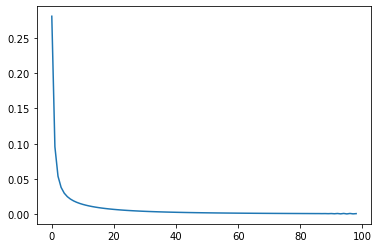

In [8]:
plt.plot(S)

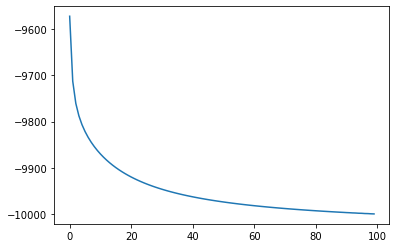

In [9]:
plt.plot(eta)

In [10]:
S[-1]

0.0006982952191938238

In [11]:
eta

array([-9572.30427082, -9712.77211491, -9760.60308382, -9787.50449291,
       -9806.46889906, -9821.37158162, -9833.77863549, -9844.46426316,
       -9853.86846659, -9862.26781772, -9869.84974492, -9876.74878026,
       -9883.06589349, -9888.87956731, -9894.25252483, -9899.23602236,
       -9903.87270614, -9908.19858358, -9912.24442702, -9916.03680142,
       -9919.59883507, -9922.95081007, -9926.11062317, -9929.09415154,
       -9931.91554722, -9934.58747727, -9937.12132178, -9939.52733893,
       -9941.8148036 , -9943.99212485, -9946.06694618, -9948.04623148,
       -9949.93633935, -9951.74308753, -9953.47180907, -9955.12740151,
       -9956.7143701 , -9958.2368659 , -9959.69871948, -9961.10347085,
       -9962.45439606, -9963.75453095, -9965.00669239, -9966.2134973 ,
       -9967.37737971, -9968.50060621, -9969.58528975, -9970.6334022 ,
       -9971.6467857 , -9972.6271629 , -9973.57614629, -9974.49524674,
       -9975.38588111, -9976.2493794 , -9977.0869911 , -9977.89989109,
      

In [12]:
eta_adj = eta - eta[-1]

In [13]:
eta_adj

array([4.27095729e+02, 2.86627885e+02, 2.38796916e+02, 2.11895507e+02,
       1.92931101e+02, 1.78028418e+02, 1.65621364e+02, 1.54935737e+02,
       1.45531533e+02, 1.37132182e+02, 1.29550255e+02, 1.22651220e+02,
       1.16334106e+02, 1.10520433e+02, 1.05147475e+02, 1.00163978e+02,
       9.55272937e+01, 9.12014163e+01, 8.71555728e+01, 8.33631985e+01,
       7.98011648e+01, 7.64491898e+01, 7.32893767e+01, 7.03058483e+01,
       6.74844526e+01, 6.48125226e+01, 6.22786781e+01, 5.98726609e+01,
       5.75851963e+01, 5.54078750e+01, 5.33330537e+01, 5.13537684e+01,
       4.94636605e+01, 4.76569123e+01, 4.59281908e+01, 4.42725984e+01,
       4.26856298e+01, 4.11631340e+01, 3.97012804e+01, 3.82965290e+01,
       3.69456038e+01, 3.56454689e+01, 3.43933075e+01, 3.31865026e+01,
       3.20226202e+01, 3.08993937e+01, 2.98147101e+01, 2.87665977e+01,
       2.77532142e+01, 2.67728370e+01, 2.58238536e+01, 2.49047531e+01,
       2.40141188e+01, 2.31506205e+01, 2.23130088e+01, 2.15001088e+01,
      